 ### -> Regularisation used = L2  
 ### -> Gradient Descent used = Mini-batch Gradient Descent  
 ### -> Activation Funtions = Relu(for 1 to L-1 layers) and Sigmoid(for Lth layer)

In [123]:
import h5py
import cv2
from pathlib import Path
import image_duplicate_remover
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import math
from IPython.display import clear_output
import time

#### Remove duplicate images from existing classifier

In [2]:
# Remove duplicates by my image_duplicate_remover.py file made by me to detect duplicates using hash function
path = r"C:\Users\abhin\Projects\google-images-deep-learning\images"
image_duplicate_remover.path_files(path)

0 to view duplicates.
1 to remove duplicates.
0


### Building a image dataset with h5py file

In [3]:
def path_files(path):
    paths = []
    images= []
    folders = Path(path)
    for folder in folders.iterdir():
        for file in folder.iterdir():
            paths.append(str(file))
            images.append(str(file.name))
    return paths, images

In [4]:
paths , images = path_files(path)

In [5]:
height , width = 100, 100

In [6]:
def dataset_h5py(paths, images, height , width): 
    start = dt.datetime.now()
    with h5py.File('data.h5', 'w') as hf:
        for i , file in enumerate(paths):
            img = cv2.imread(file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(img, (height , width))
            Xset = hf.create_dataset(name='X'+str(i),
                                    data=image,
                                    shape=(height , width),
                                    compression="gzip",
                                    compression_opts=9)

            if images[i].split("_")[0] == "object":
                yset = hf.create_dataset(name='y'+str(i),
                        data = 0,
                        shape=(1,),
                        compression="gzip",
                        compression_opts=9)
            else: 
                yset = hf.create_dataset(name='y'+str(i),
                        data = 1,
                        shape=(1,),
                        compression="gzip",
                        compression_opts=9)

    end=dt.datetime.now()
    print("\r", len(images), ": ", (end-start).seconds, "seconds", end="")       

In [8]:
dataset_h5py(paths, images, height , width)

 2772 :  59 seconds

[1]


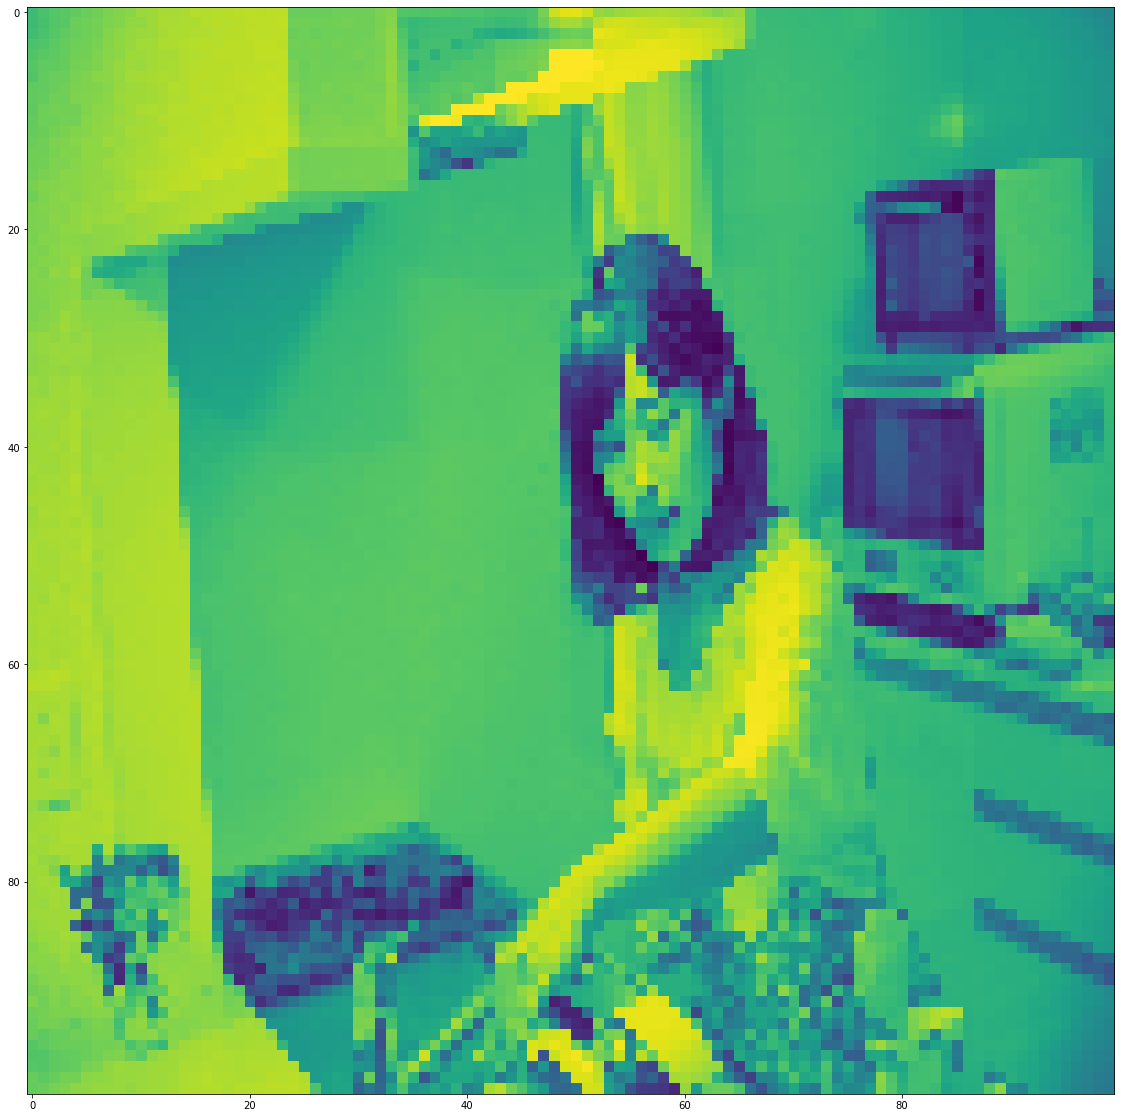

In [93]:
with h5py.File('data.h5', 'r') as hf:
    plt.imshow(hf["X12"])
    print(hf["y12"].value)

#### Loading the dataset

In [94]:
with h5py.File('data.h5', 'r') as hf:
    X = [hf["X"+str(x)][:] for x in range(2772)]
    Y = [hf["y"+str(x)][:] for x in range(2772)]
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape[0] , -1).T
Y = Y.T

In [95]:
train_length = 2472
permutation = np.random.permutation(X.shape[1])
X = X[: , permutation]
Y = Y[: , permutation]
X_train = X[: , :train_length]
X_test = X[:, train_length: ]
Y_train = Y[: , :train_length]
Y_test = Y[:, train_length: ]
X_train = X_train/255
X_test = X_test/255

### Building the DNN model from scratch

In [96]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

In [97]:
def relu(Z):

    A = np.maximum(0,Z)
    
    cache = Z 
    return A, cache

In [98]:
def relu_backward(dA, cache):
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    return dZ

In [99]:
def sigmoid_backward(dA, cache):
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    return dZ

In [100]:
def initialize_parameters_deep(layer_dims):
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2/layers_dims[l-1]) * 0.01  
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
       
    return parameters

In [101]:
def linear_forward(A, W, b):
    Z = W.dot(A) + b

    cache = (A, W, b)
    
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):

    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    cache = (linear_cache, activation_cache)

    return A, cache

In [102]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)

            
    return AL, caches

In [103]:
def compute_cost(AL, Y , layers_dims, parameters, lamd , m):
    epsilon = 1e-8

    # Compute loss from aL and y.
    cost = (1/m) * (-np.dot(Y,np.log(AL + epsilon).T) - np.dot(1-Y, np.log(1- AL + epsilon).T))
    l2_regularization_cost=0
    for l in range(1, len(layers_dims)):
        l2_regularization_cost += np.sum(np.sum(parameters["W"+str(l)] * parameters["W"+str(l)]))
    
    l2_regularization_cost = l2_regularization_cost * lamd/(2*m)
    cost = cost + l2_regularization_cost
    
    
    cost = np.squeeze(cost)      
    
    return cost

In [104]:
def linear_backward(dZ, cache, lamd , m):
    A_prev, W, b = cache


    dW = 1/m * np.dot(dZ, cache[0].T) + lamd/m * W
    db = 1/m * np.sum(dZ, axis=1, keepdims= True)
    dA_prev = np.dot(cache[1].T, dZ)

    return dA_prev, dW, db


def linear_activation_backward(dA, cache,  lamd, m, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache, lamd, m)

        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache, lamd, m)
    
    return dA_prev, dW, db

In [105]:
def L_model_backward(AL, Y, caches, lamd, m):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, lamd, m, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, lamd, m, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [106]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

In [107]:
def random_mini_batches(X, Y, mini_batch_size = 64):
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, (k * mini_batch_size) : ((k+1) * mini_batch_size)]
        mini_batch_Y = shuffled_Y[:, (k * mini_batch_size) : ((k+1) * mini_batch_size)]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, (num_complete_minibatches * mini_batch_size) : ]
        mini_batch_Y = shuffled_Y[:, (num_complete_minibatches * mini_batch_size) : ]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [108]:
def L_layer_model(X, Y, layers_dims, lamd, mini_batch_size, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    start = dt.datetime.now()
    costs = []                         # keep track of cost
    m= X.shape[1]
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        startepoch = dt.datetime.now()
        
        minibatches = random_mini_batches(X, Y, mini_batch_size)
        cost_total = 0
        for minibatch in minibatches:
            
            (minibatch_X, minibatch_Y) = minibatch
            
            # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
            AL, caches = L_model_forward(minibatch_X, parameters)



            cost_total += compute_cost(AL, minibatch_Y, layers_dims ,parameters, lamd, m)



            grads = L_model_backward(AL, minibatch_Y, caches, lamd, m)



            parameters = update_parameters(parameters, grads, learning_rate)

        cost_avg = cost_total / m
                
        # Print the cost every 100 training example
        if print_cost and i % 5 == 0:
            endepoch = dt.datetime.now()
            print(f"Cost after iteration {i}: {cost_avg}  Time: {((endepoch-startepoch).seconds) * 5} seconds")
        if print_cost and i % 5 == 0:
            costs.append(cost_avg)
    end = dt.datetime.now()        
    # plot the cost
    print(f"Total time: {((end - start).seconds)/3600} hrs")
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [109]:
l0 = X.shape[0]
l1 = 4096
l2 = 2048
l3 = 1024
l4 = 512
l5 = 256
l6 = 128
l7 = 64
l8 = 1
layers_dims = [l0, l1, l2, l3, l4 , l5 , l6 , l7 , l8]

In [110]:
layers_dims

[10000, 4096, 2048, 1024, 512, 256, 128, 64, 1]

Cost after iteration 0: 0.000278837601649051  Time: 160 seconds
Cost after iteration 5: 0.00026483394460237756  Time: 150 seconds
Cost after iteration 10: 0.0002550869042394144  Time: 145 seconds
Cost after iteration 15: 0.0002483205241764616  Time: 145 seconds
Cost after iteration 20: 0.00024361210191997407  Time: 145 seconds
Cost after iteration 25: 0.00024029422024786972  Time: 155 seconds
Cost after iteration 30: 0.0002379839311296563  Time: 155 seconds
Cost after iteration 35: 0.00023630881501813852  Time: 135 seconds
Cost after iteration 40: 0.00023510011059336316  Time: 155 seconds
Cost after iteration 45: 0.0002342064948122892  Time: 135 seconds
Cost after iteration 50: 0.00023359125943645857  Time: 135 seconds
Cost after iteration 55: 0.0002331256935648729  Time: 140 seconds
Cost after iteration 60: 0.000232798255583861  Time: 135 seconds
Cost after iteration 65: 0.00023255044786212652  Time: 130 seconds
Cost after iteration 70: 0.00023236738769618278  Time: 140 seconds
Cost a

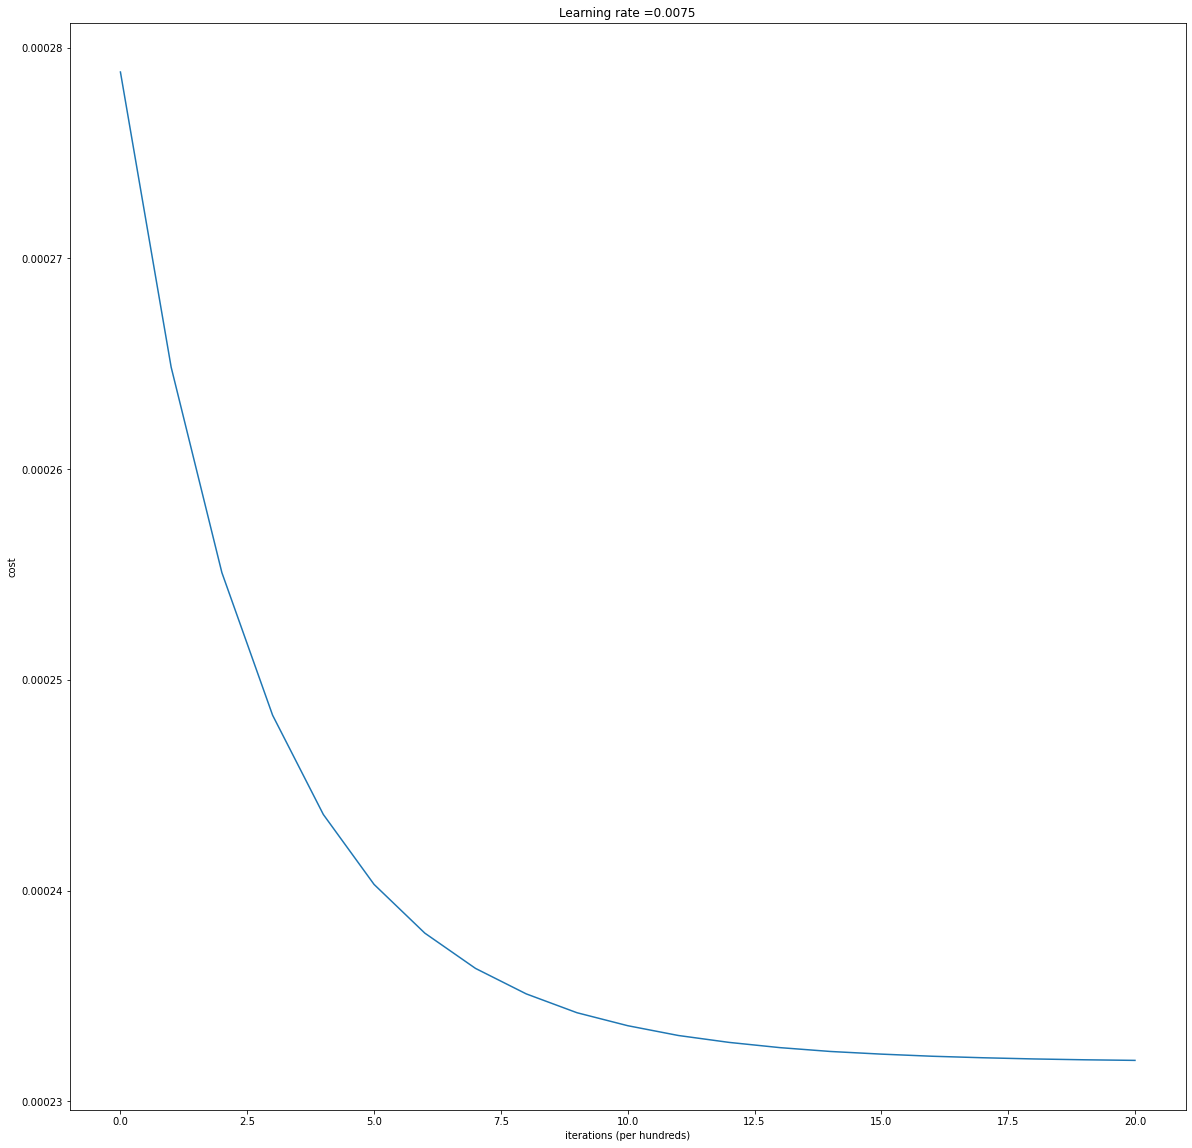

In [115]:
parameters = L_layer_model(X_train, Y_train, layers_dims, lamd =0.1, mini_batch_size=128, num_iterations = 101, print_cost = True)

In [116]:
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [117]:
pred_train = predict(X_train, Y_train, parameters)

Accuracy: 0.7398867313915859


In [118]:
pred_test = predict(X_test, Y_test, parameters)

Accuracy: 0.76


In [119]:
def print_mislabeled_images(X, y, p):
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40, 40) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(100, 100), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + str(y[0,index]))

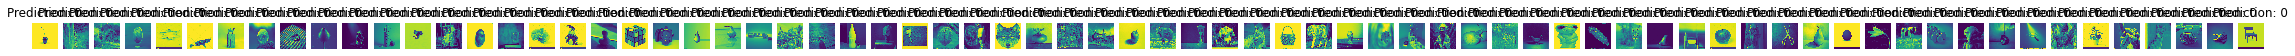

In [120]:
print_mislabeled_images(X_test, Y_test, pred_test)